<a id="0"></a> <br>
 # Table of Contents  
1. [Set up, plot functions](#1)     
1. [Plotting (example commands)](#2)
1. Different ways to view dataplots
    1. [Scan through in order](#3)
    1. [Choose country by indicies](#4)
    1. [By country](#5)
1. [View top individual mutations (beta)](#6)

<a id="1"></a>
### Setup and functions
#### Run the cell below to initialize functions, then plot with options below

In [4]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib as mpl  
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
import re
import datetime

# global variables: colormap

cmap = cm.get_cmap('Spectral')
rgba1 = cmap(0)
rgba2 = cmap(0.25)
rgba3 = cmap(0.5)
rgba4 = cmap(0.75)
rgba5 = cmap(0.9)
rgba6 = cmap(0.99) 

# paths

#username           = 'YOUR_PATH_HERE'

home_dir           = os.path.join(username, 'paper-epi-backprojection/data/analysis-visualization')
data_dir           = os.path.join(username, 'paper-epi-backprojection/data/SC2_BP_Data')
inf_plot_home      = os.path.join(home_dir, 'inference-plotting')
inf_plot_bp_home   = os.path.join(home_dir, 'inference-plotting-bp')

# helper date function

def get_day(day):
    ref_date = datetime.date(2020, 1, 1)
    target = ref_date + datetime.timedelta(day)
    return(target.strftime("%m-%d-%y"))

# helper sizing function

def cm2inch(x): 
    return float(x)/2.54

# global variables: paper size

SINGLE_COLUMN = cm2inch(8.8)
DOUBLE_COLUMN = cm2inch(18.0)

# helper function, color spectrum legend

def extract_numeric(arr):
    numeric_values = []
    for item in arr:
        match = re.match(r'(\d+)', str(item))
        if match:
            numeric_values.append(int(match.group(1)))
    return np.array(numeric_values)

# loading function

def load_npz_covar(path):
    
    # path is your targeted country
    npz_files = [f for f in os.listdir(path) if f != ".DS_Store"]
    # concats times and counts across time ranges if necessary for back projection comparison
    time_l = []
    count_l = []
    for file in sorted(npz_files):
        filepath = os.path.join(path, file)
        data = np.load(filepath, allow_pickle=True)
        times = data['times']
        counts = data['counts']
        refs = data['ref_sites']
        time_l.append(times)
        count_l.append(counts)

    x = np.concatenate(time_l)
    y = np.concatenate(count_l)
    z = refs
    
    # for finding date ranges

    #print(np.min(x))
    #print(np.max(x))
    #print(np.min(x) , '-' , np.max(x))
    #print(str(abs(np.min(x)-np.max(x))))

    return x, y, z

# plot functions
# color bar legend added:

def plot_covar(x, y, z, plot_label):
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    index_drop = []

    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]

    df = df[~df['ref_index'].isin(index_drop)]

    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.4, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    #ax.tick_params(axis='x', labelrotation = 45)
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    title_label = plot_label.split('_')[0]
    plt.title(f'Frequency trajectories: {title_label}', font='Avenir', size=20, pad=20)
    
    ref_sites = extract_numeric(z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Avenir', size=16, labelpad=20)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    
    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Avenir')
        label.set_fontsize(12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    plt.show()

    return fig

def plot_times_covar(x, y, z, plot_label, start_time, end_time):
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    index_drop = []

    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]

    df = df[~df['ref_index'].isin(index_drop)]

    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    #ref_date = datetime.date(2020, 1, 1)
    #x_days = [int(day) for day in x]
    #x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            #ax.plot(x_dates, y_line, linewidth=1.4, color=color)
            ax.plot(x_line, y_line, linewidth=1.4, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    #ax.tick_params(axis='x', labelrotation = 45)
    #fig.autofmt_xdate()
    
    ax.set_xlim(start_time, end_time)

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    title_label = plot_label.split('_')[0]
    plt.title(f'Frequency trajectories: {title_label}', font='Avenir', size=20, pad=20)
    
    ref_sites = extract_numeric(z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Avenir', size=16, labelpad=20)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    
    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Avenir')
        label.set_fontsize(12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    plt.show()

    return fig

def plot_spike_covar(x, y, z, plot_label):
    
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(num_lines):
        site_label = new_labels[i]

        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)

        col = 'k' if (21562 <= site_value < 25384) else 'green'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=1.4, color=col)
            
    spike_patch = mpatches.Patch(color='k', label='Spike')
    other_patch = mpatches.Patch(color='green', label='Other')
    ax.legend(handles=[spike_patch, other_patch], bbox_to_anchor=(1.15, 1.0), loc='upper right', fontsize=12)
    #ax.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    
    plt.subplots_adjust(bottom=0.15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    title_label = plot_label.split('_')[0]
    plt.title(f'Frequency trajectories: {title_label}', font='Avenir', size=20, pad=20)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    plt.show()

    return fig

# color bar legend added:

def plot_save_covar(x, y, z, plot_label):
    
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    index_drop = []

    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]

    df = df[~df['ref_index'].isin(index_drop)]

    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(10, 4))
    
    for i in range(num_lines):
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=1.4, color=color)
    
    plt.subplots_adjust(bottom=0.15)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    ref_sites = extract_numeric(z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Avenir', size=16, labelpad=20)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    
    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Avenir')
        label.set_fontsize(12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')


    save_path = username + f'/paper-epi-backprojection/figures/covar_display_{plot_label}.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

# binarized spike trajectories
def plot_save_spike_covar(x, y, z, plot_label):
    
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    fig, ax = plt.subplots(figsize=(10, 4))

    for i in range(num_lines):
        site_label = new_labels[i]
        
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        col = 'k' if (21562 <= site_value < 25384) else 'green'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=1.4, color=col)
    
    spike_patch = mpatches.Patch(color='k', label='Spike')
    other_patch = mpatches.Patch(color='green', label='Other')
    ax.legend(handles=[spike_patch, other_patch], bbox_to_anchor=(1.15, 1.0), loc='upper right', fontsize=12)
    plt.tight_layout()
    
    plt.subplots_adjust(bottom=0.15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    save_path = username + f'/paper-epi-backprojection/figures/covar_display_spike_{plot_label}.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

def plot_inf(x, y, index):
    
    #plt.subplots(figsize=(12,12))
    plt.subplots(figsize=(8,8))
    plt.plot(x, y, 'o', color=rgba1, markersize=3)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6)

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=2)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)

    ax.set_xlabel('Coefficients, sample collection times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Coefficients, inferred infection times', font='Avenir', size=16, labelpad=10)
    plt.title('Selection coefficients comparison', font='Avenir', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
        
    plt.show()
    
    print(linregress(x, y))

def plot_save_inf(x, y, index):
    
    #plt.subplots(figsize=(12,12))
    plt.subplots(figsize=(8,8))
    plt.plot(x, y, 'o', color=rgba1, markersize=3)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6)

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=2)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)

    ax.set_xlabel('Coefficients, sample collection times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Coefficients, inferred infection times', font='Avenir', size=16, labelpad=10)
    #plt.title('Selection Coefficients: Transmissions vs. Infections', font='Avenir', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    save_path = username + f'/paper-epi-backprojection/figures/inf_display_{index}.pdf'
    print(f"saving plot to: {save_path}")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(linregress(x, y))
    
# figure functions
def covar_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    #is_consecutive = all(un_sel_x[i] == un_sel_x[i-1] + 1 for i in range(1, len(un_sel_x)))
    #is_bp_consecutive = all(bp_sel_x[i] == bp_sel_x[i-1] + 1 for i in range(1, len(bp_sel_x)))
    #print(is_consecutive, is_bp_consecutive)

    fig1 = plot_covar(un_sel_x, un_sel_y, un_ref_z, f'Sample collections_{index}')
    fig2 = plot_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections_{index}')
    return fig1, fig2

def covar_figure_times(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    #is_consecutive = all(un_sel_x[i] == un_sel_x[i-1] + 1 for i in range(1, len(un_sel_x)))
    #is_bp_consecutive = all(bp_sel_x[i] == bp_sel_x[i-1] + 1 for i in range(1, len(bp_sel_x)))
    #print(is_consecutive, is_bp_consecutive)

    start = int(input("Enter the start value as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end value as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    fig1 = plot_times_covar(un_sel_x, un_sel_y, un_ref_z, f'Sample collections_{index}', start, end)
    fig2 = plot_times_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections_{index}', start, end)
    return fig1, fig2

def covar_spike_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig1 = plot_spike_covar(un_sel_x, un_sel_y, un_ref_z, f'Sample collections_{index}')
    fig2 = plot_spike_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections_{index}')
    return fig1, fig2


def covar_save_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig1 = plot_save_covar(un_sel_x, un_sel_y, un_ref_z, f'Transmissions_{index}')
    fig2 = plot_save_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred_Infections_{index}')
    return fig1, fig2


def covar_spike_save_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig1 = plot_save_spike_covar(un_sel_x, un_sel_y, un_ref_z, f'Transmissions_{index}')
    fig2 = plot_save_spike_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred_Infections_{index}')
    return fig1, fig2

def inf_figure(index, inf_plot_home, inf_plot_bp_home, plot_function):
    
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    fig3 = plot_function(un_sel, bp_sel, index)
    return fig3

# wrapping functions for visualization

def plot_wrap(index, home_dir, inf_home, inf_bp_home, plot_function):
    
    fig1, fig2 = covar_figure(index, home_dir)
    fig3 = inf_figure(index, inf_home, inf_bp_home, plot_function)
    return fig1, fig2, fig3

def plot_times_wrap(index, home_dir, inf_home, inf_bp_home, plot_function):
    
    fig1, fig2 = covar_figure_times(index, home_dir)
    fig3 = inf_figure(index, inf_home, inf_bp_home, plot_function)
    return fig1, fig2, fig3

def plot_save_wrap(index, home_dir, inf_home, inf_bp_home, plot_function):
    
    fig1, fig2 = covar_save_figure(index, home_dir)
    fig3 = inf_figure(index, inf_home, inf_bp_home, plot_function)
    return fig1, fig2, fig3

def plot_spike_wrap(index, home_dir, inf_home, inf_bp_home, plot_function):
    
    fig1, fig2 = covar_spike_figure(index, home_dir)
    fig3 = inf_figure(index, inf_home, inf_bp_home, plot_function)
    return fig1, fig2, fig3


def plot_save_spike_wrap(index, home_dir, inf_home, inf_bp_home, plot_function):
    
    fig1, fig2 = covar_spike_save_figure(index, home_dir)
    fig3 = inf_figure(index, inf_home, inf_bp_home, plot_function)
    return fig1, fig2, fig3

<a id="2"></a>
### examples (using index)

saving plot to: /Users/liz/Documents/Github/paper-epi-backprojection/figures/covar_display_Transmissions_4.pdf
saving plot to: /Users/liz/Documents/Github/paper-epi-backprojection/figures/covar_display_Inferred_Infections_4.pdf
saving plot to: /Users/liz/Documents/Github/paper-epi-backprojection/figures/inf_display_4.pdf
LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)


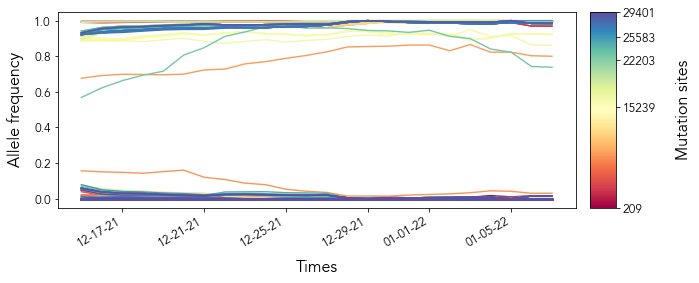

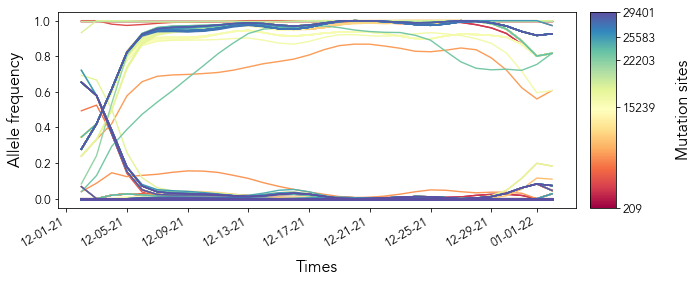

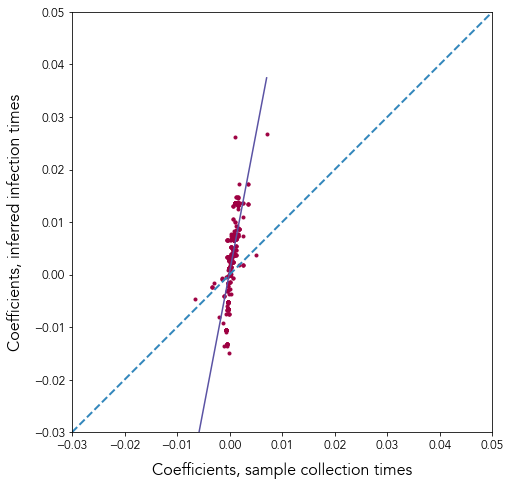

In [5]:
%matplotlib inline

#fig1, fig2, fig3 = plot_wrap(4, home_dir, inf_plot_home, inf_plot_bp_home, plot_save_inf)
#fig1, fig2, fig3 = plot_times_wrap(4, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)
#fig1, fig2, fig3 = plot_spike_wrap(4, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)
#fig1, fig2, fig3 = plot_save_spike_wrap(4, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)
fig1, fig2, fig3 = plot_save_wrap(4, home_dir, inf_plot_home, inf_plot_bp_home, plot_save_inf)

matplotlib notebook useful for exploring large time series

<IPython.core.display.Javascript object>


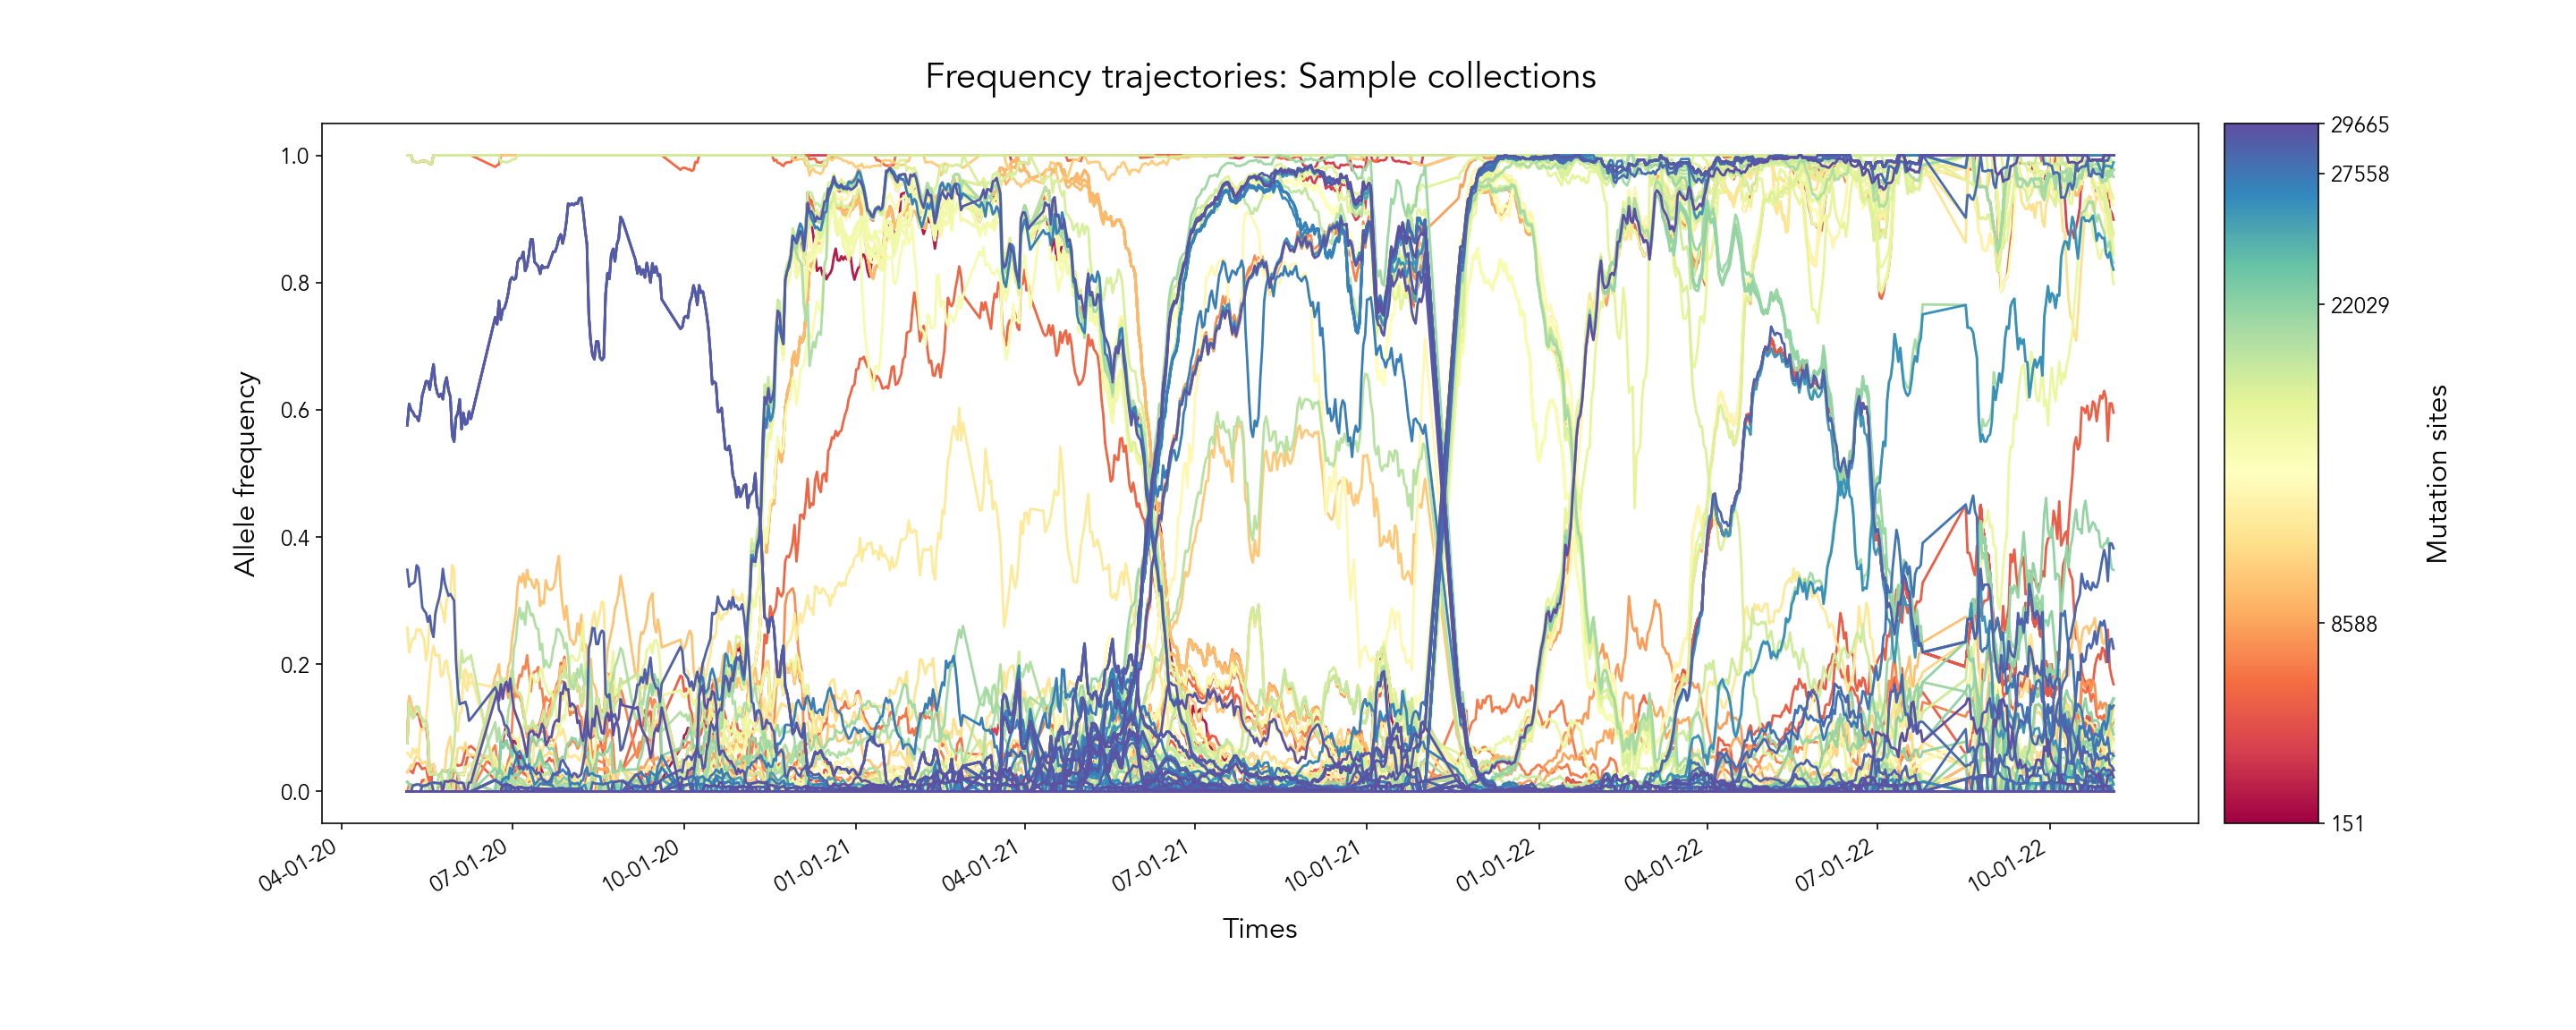

<IPython.core.display.Javascript object>


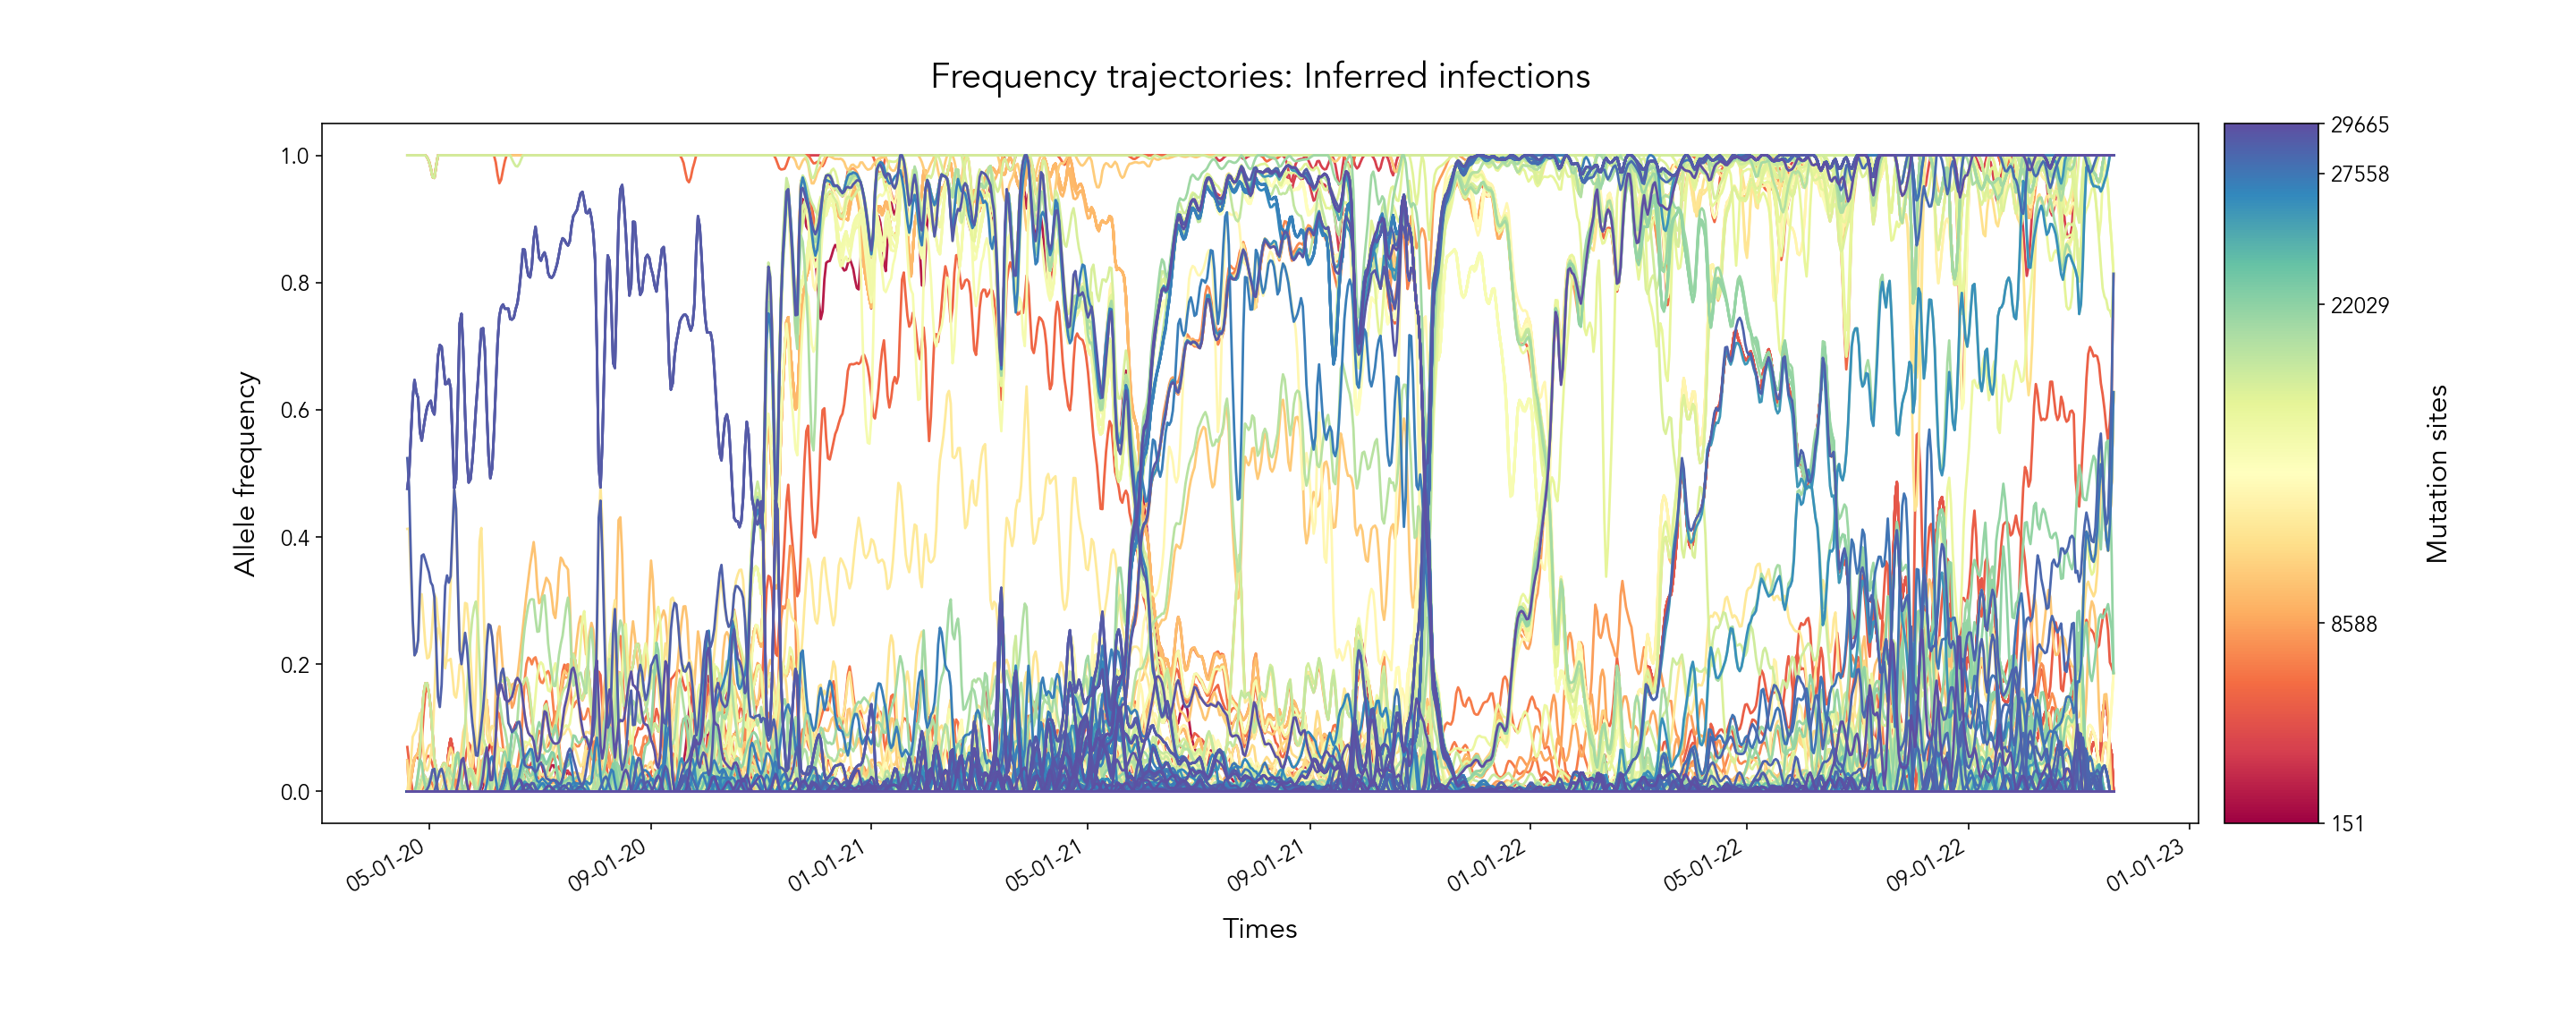

<IPython.core.display.Javascript object>


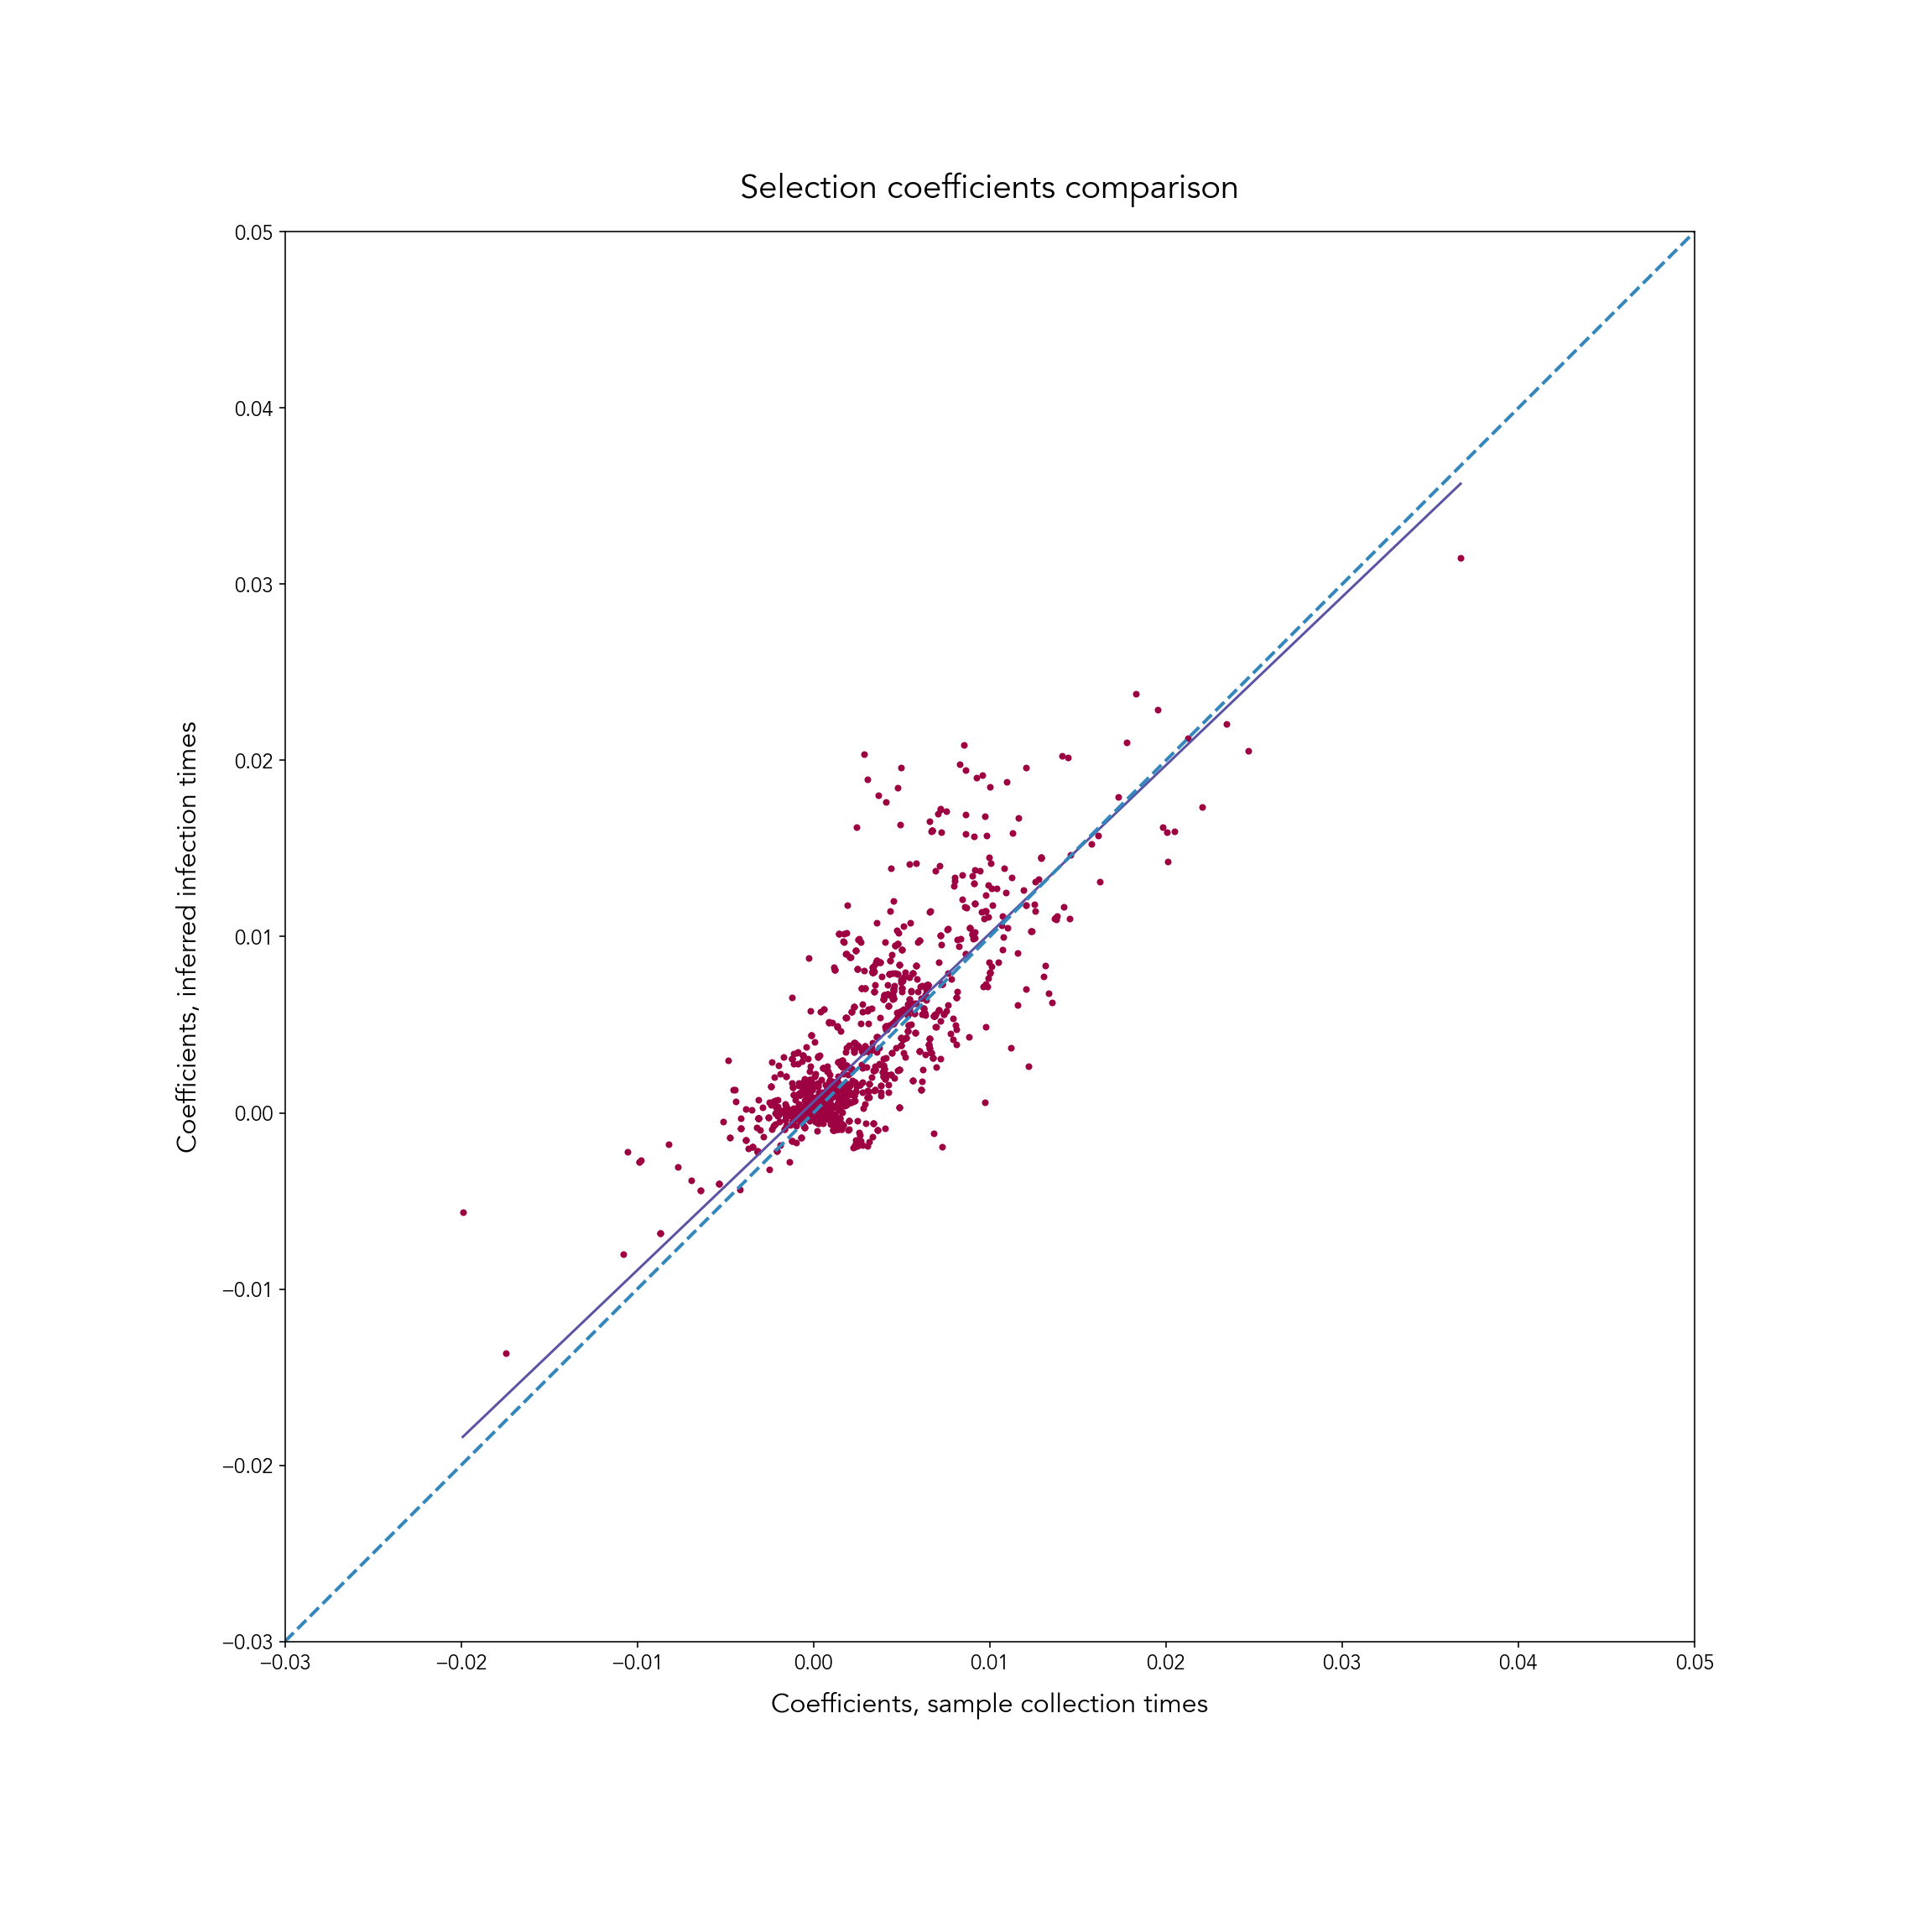

LinregressResult(slope=0.955276591778143, intercept=0.0006223131876729804, rvalue=0.8204990361436986, pvalue=0.0, stderr=0.013479160020083526, intercept_stderr=5.0958298119301085e-05)


In [5]:
%matplotlib notebook

fig1, fig2, fig3 = plot_wrap(11, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)

<a id="3"></a>
### View by scanning through indices (in order)

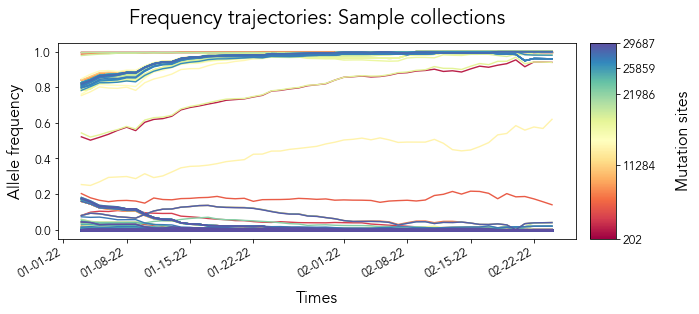

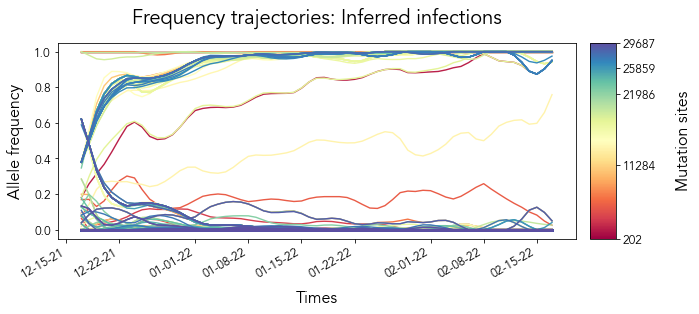

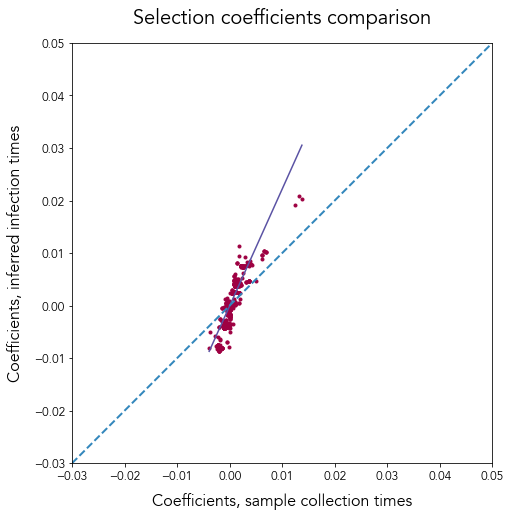

LinregressResult(slope=2.222984589452873, intercept=-5.1621537102829835e-05, rvalue=0.8824821056346607, pvalue=0.0, stderr=0.028668438590459727, intercept_stderr=3.4159427989405915e-05)
Press Enter to continue or q to quit: 


In [30]:
from IPython.display import clear_output
%matplotlib inline

for i in range(0, 108):
    if i == 29:
        continue
    fig1, fig2, fig3 = plot_wrap(i, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)
    user_input = input("Press Enter to continue or q to quit: ")
    if user_input.lower() == 'q':
        break
    clear_output(wait=True)
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

<a id="4"></a>
### View by choosing a specific indicies

In [7]:
from IPython.display import clear_output
%matplotlib inline

while True:
    try:
        user_input = input("Enter an index from 0 to 108 or q to quit: ")
        if user_input.lower() == 'q':
            break
        index = int(user_input)
        if 0 <= index <= 108:
            fig1, fig2, fig3 = plot_wrap(index, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)
            clear_output(wait=True)
            plt.close(fig1)
            plt.close(fig2)
            plt.close(fig3)
        else:
            print("Invalid index")
    except ValueError:
        print("Invalid input")

Enter an index from 0 to 108 or q to quit: q


<a id="5"></a>
### View by country

In [8]:
#Africa

Cameroon = [0]
Kenya = [1,2,3,4]
Reunion = [5,6,7,8,9,10]
SouthAfrica = [11,12]

#Asia

HongKong = [13,14,15,16,17,18]
Gujarat = [19,20,21,22,23,24,25,26]
Karnataka = [27,28]
Indonesia = [29] #broken
Vietnam = [30,31,32,33,34]

#Europe

BosniaHerzegovina = [35,36,37]
Croatia = [38,39,40]
Cyprus = [41,42,43,44,45]
Estonia = [46,47,48]
Latvia = [49]
Portugal = [50,51,52,53]
Romania = [54,55,56,57,58,59]
Moscow = [60,61,62,63,64,65]
Slovakia = [66,67]

#North America

Manitoba = [68,69,70,71,72,73,74,75,76,77,78,79,80]
Quebec = [81,82,83,84,85]
CostaRica = [86]
Jamaica = [87,88,89]
MexicoCity = [90,91,92,93]
NuevoLeon = [94,95,96]
Panama = [97,98,99]
PuertoRico = [100,101,102,103,104,105]
Wyoming = [106,107]

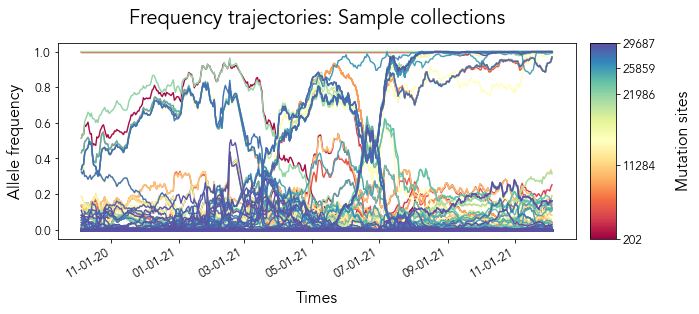

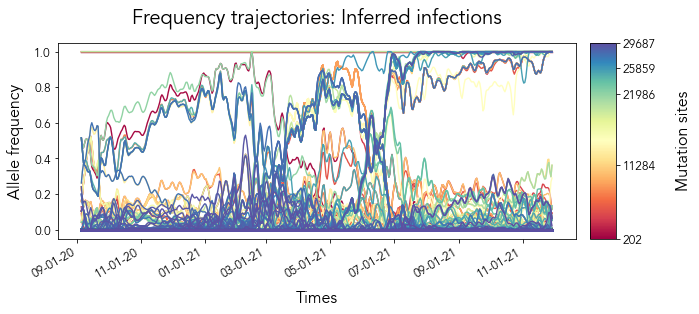

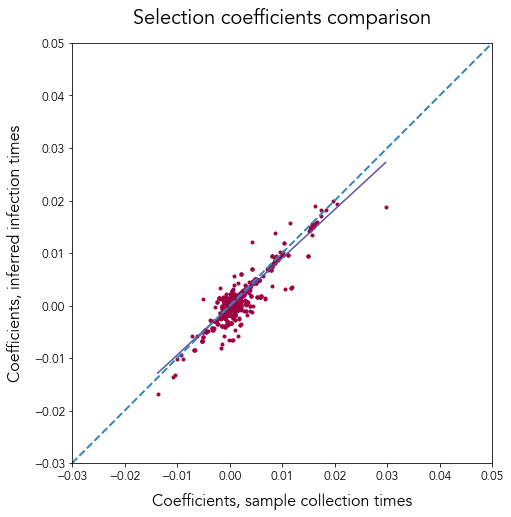

LinregressResult(slope=0.9237993414736301, intercept=-0.00018232426145823265, rvalue=0.9301687426637306, pvalue=0.0, stderr=0.00882255843987355, intercept_stderr=3.221181417933055e-05)


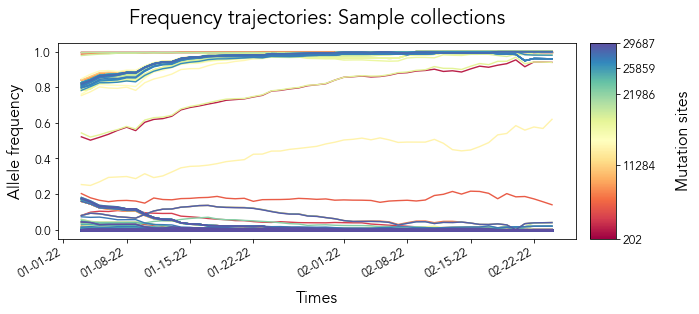

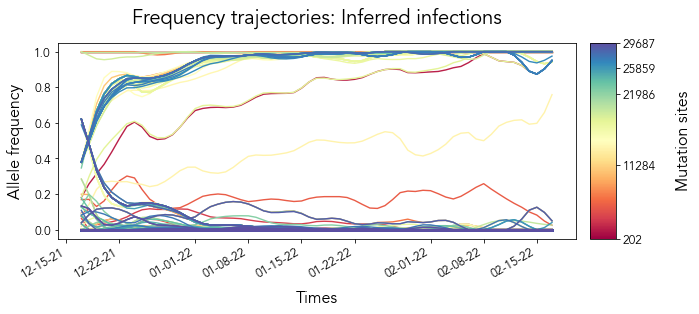

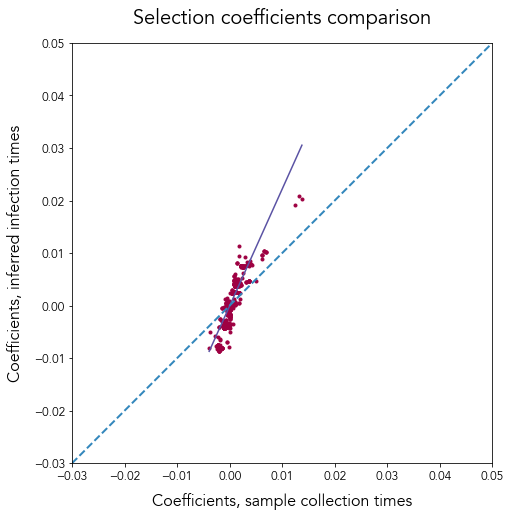

LinregressResult(slope=2.222984589452873, intercept=-5.1621537102829835e-05, rvalue=0.8824821056346607, pvalue=0.0, stderr=0.028668438590459727, intercept_stderr=3.4159427989405915e-05)


In [10]:
# change line of code to view

%matplotlib inline
for i in Wyoming:
    fig1, fig2, fig3 = plot_wrap(i, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)

#### View by country input (case insensitive)

In [11]:
def get_region_plots():
    
    regions_dict = {
        # Africa
        "Cameroon": [0],
        "Kenya": [1, 2, 3, 4],
        "Reunion": [5, 6, 7, 8, 9, 10],
        "SouthAfrica": [11, 12],

        # Asia
        "HongKong": [13, 14, 15, 16, 17, 18],
        "Gujarat": [19, 20, 21, 22, 23, 24, 25, 26],
        "Karnataka": [27, 28],
        "Indonesia": [29],  # broken
        "Vietnam": [30, 31, 32, 33, 34],

        # Europe
        "BosniaHerzegovina": [35, 36, 37],
        "Croatia": [38, 39, 40],
        "Cyprus": [41, 42, 43, 44, 45],
        "Estonia": [46, 47, 48],
        "Latvia": [49],
        "Portugal": [50, 51, 52, 53],
        "Romania": [54, 55, 56, 57, 58, 59],
        "Moscow": [60, 61, 62, 63, 64, 65],
        "Slovakia": [66, 67],

        # North America
        "Manitoba": [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
        "Quebec": [81, 82, 83, 84, 85],
        "CostaRica": [86],
        "Jamaica": [87, 88, 89],
        "MexicoCity": [90, 91, 92, 93],
        "NuevoLeon": [94, 95, 96],
        "Panama": [97, 98, 99],
        "PuertoRico": [100, 101, 102, 103, 104, 105],
        "Wyoming": [106, 107]
    }

    while True:
        region = input("Enter region or 'q' to quit (case-insensitive): ")

        if region.lower() == 'q':
            break
        
        selected_region = regions_dict.get(region.capitalize())

        if selected_region is None:
            available_regions = ", ".join(regions_dict.keys())
            print(f"Region not available. Available regions: {available_regions}")
        else:
            for i in selected_region:
                fig1, fig2, fig3 = plot_wrap(i, home_dir, inf_plot_home, inf_plot_bp_home, plot_inf)

Enter region or 'q' to quit (case-insensitive): Kenya


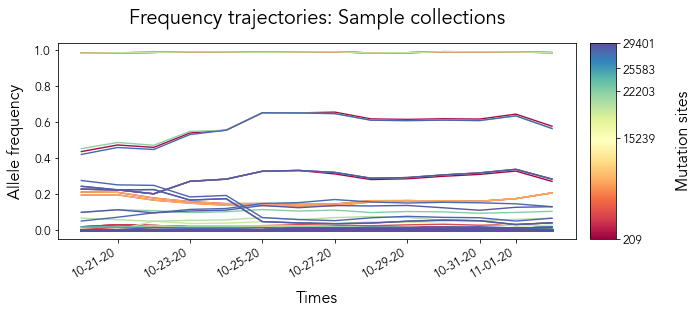

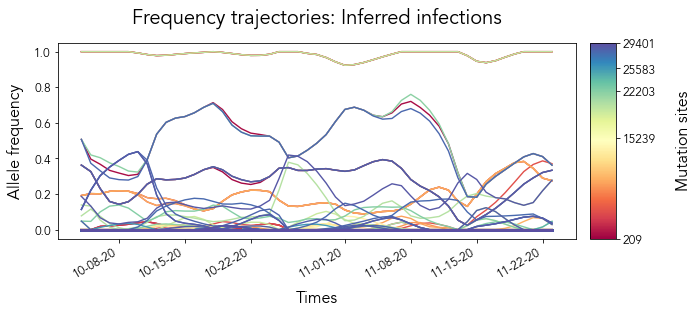

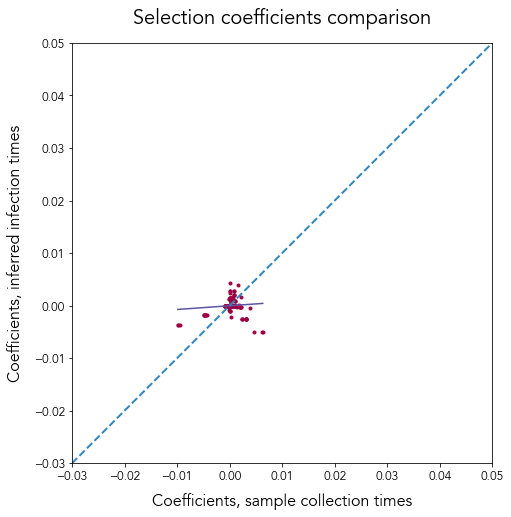

LinregressResult(slope=0.07083505129872569, intercept=-2.6377423239911696e-05, rvalue=0.10735012856370557, pvalue=0.002017464941466114, stderr=0.02286803139903502, intercept_stderr=2.2016626444889266e-05)


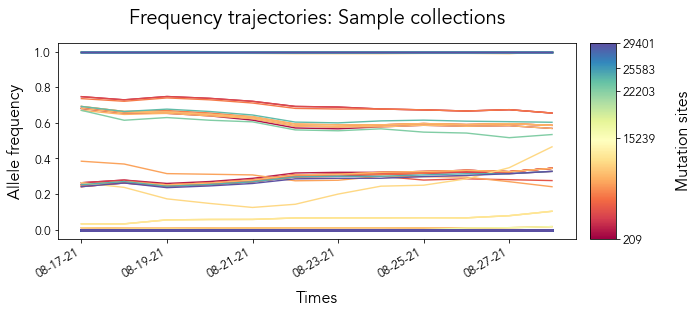

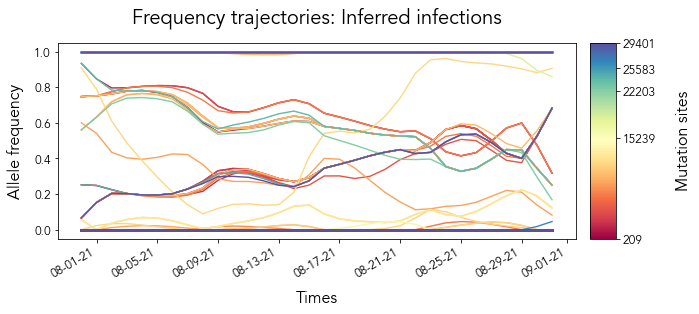

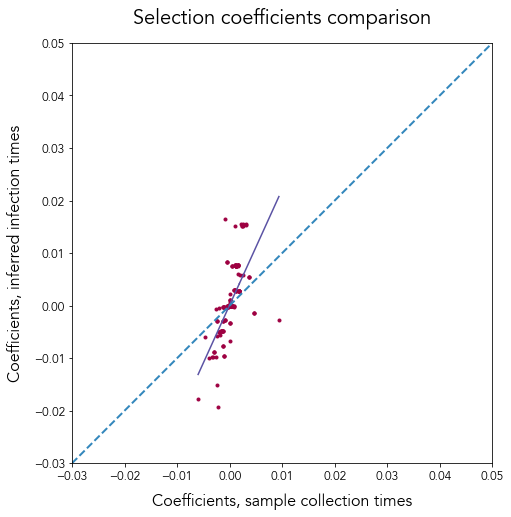

LinregressResult(slope=2.202264176972864, intercept=0.00010996265740114154, rvalue=0.6457855055917144, pvalue=1.5630280736742316e-98, stderr=0.09076135781528065, intercept_stderr=7.545209296495261e-05)


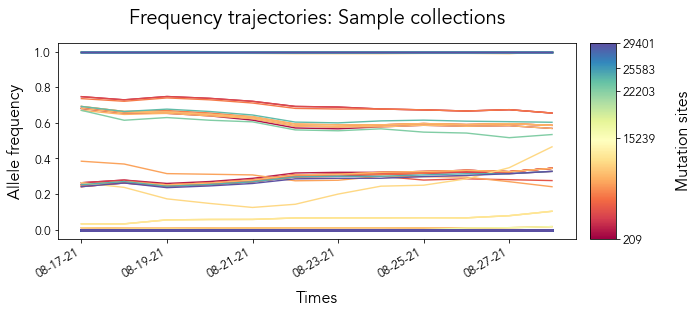

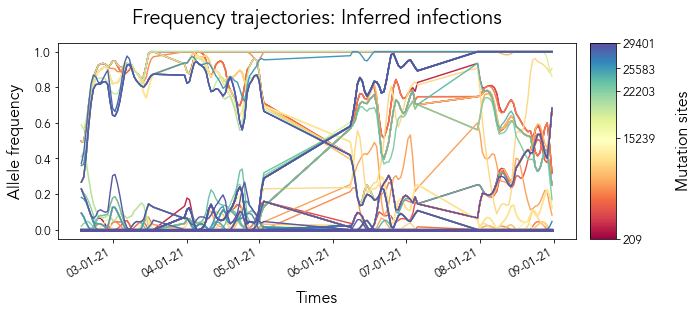

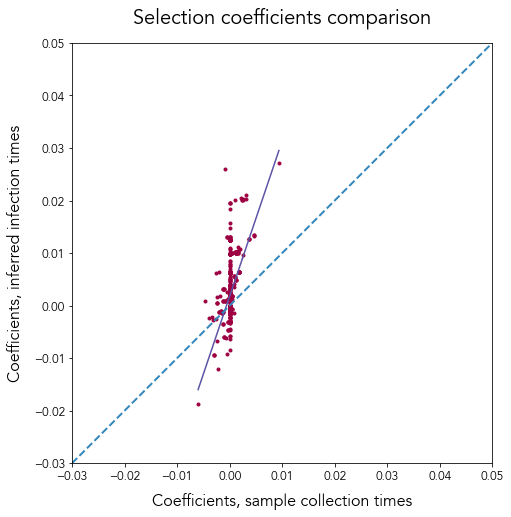

LinregressResult(slope=2.95931934918827, intercept=0.0017656184219996041, rvalue=0.5095827572522729, pvalue=1.0065355609503692e-55, stderr=0.174176083448133, intercept_stderr=0.0001447967544441836)


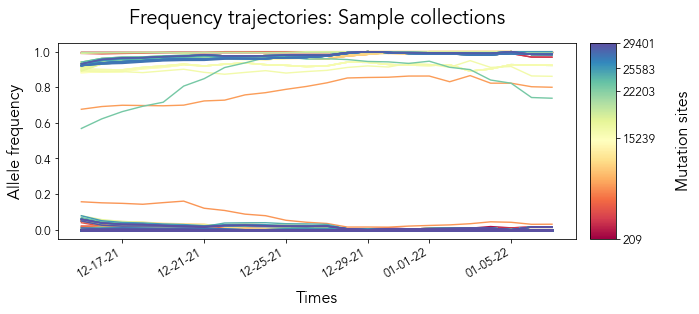

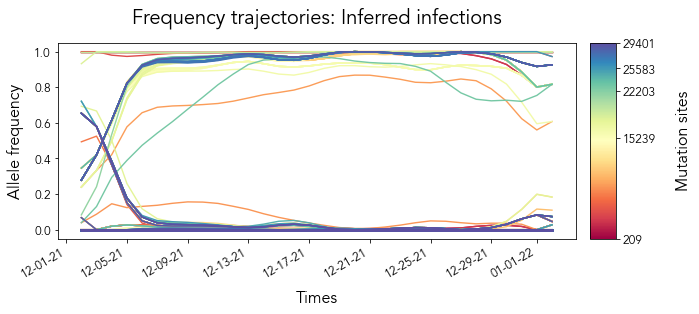

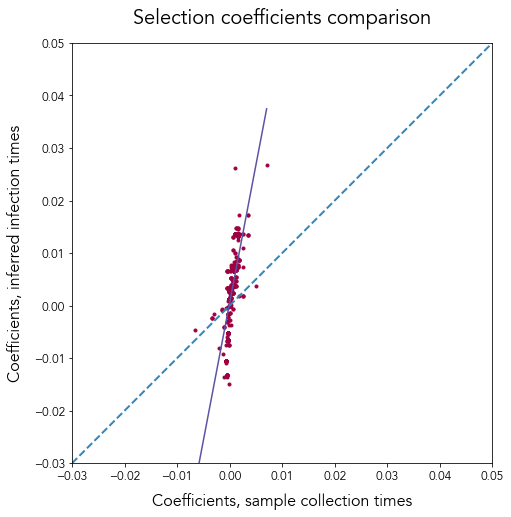

LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)
Enter region or 'q' to quit (case-insensitive): q


In [12]:
get_region_plots()

<a id="6"></a>
### this plots top individual mutations for functional investigation (beta code)

In [13]:
def plot_topMut_inf(x, y, mut1, mut2, index):
    
    #plt.subplots(figsize=(12,12))
    plt.subplots(figsize=(8,8))
    y_val = y > 0.015
    indices_where = np.where(y_val)
    print(indices_where)
    #mutant = input(str("type mutation: "))
    print(mut1[0][indices_where])
    for i in indices_where:
        plt.plot(x[i], y[i], 'o', label=mut2, color=rgba1, markersize=3)
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6)

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=2)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)

    ax.set_xlabel('Coefficients, sample collection times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Coefficients, inferred infection times', font='Avenir', size=16, labelpad=10)
    plt.title('Selection coefficients comparison', font='Avenir', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
        
    plt.show()
    
    print(linregress(x, y))
    
def inf_topMut_figure(index, inf_plot_home, inf_plot_bp_home, plot_function):
     
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    #for file in y:
    #    print(file)
    
    #print(len(y['mutant_sites'][0]))
    un_sel = x['selection']
    bp_sel = y['selection']
    
    un_mut = x['mutant_sites']
    bp_mut = y['mutant_sites']
    
    fig3 = plot_function(un_sel, bp_sel, un_mut, bp_mut, index)
    return fig3

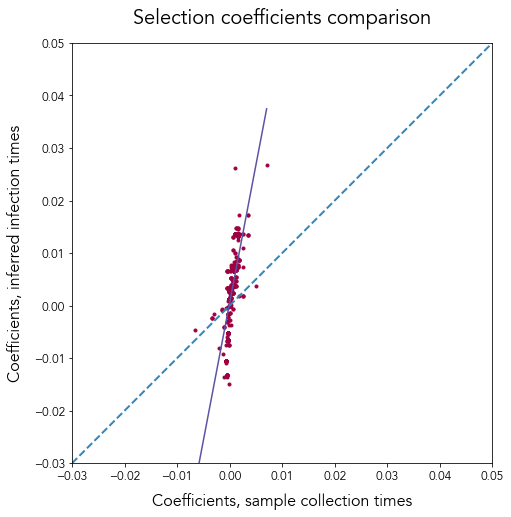

LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)


In [14]:
inf_figure(4, inf_plot_home, inf_plot_bp_home, plot_inf)

(array([290, 484, 488, 604, 638]),)
['21766--' '22812-T' '22881-G' '24999-T' '26529-G']


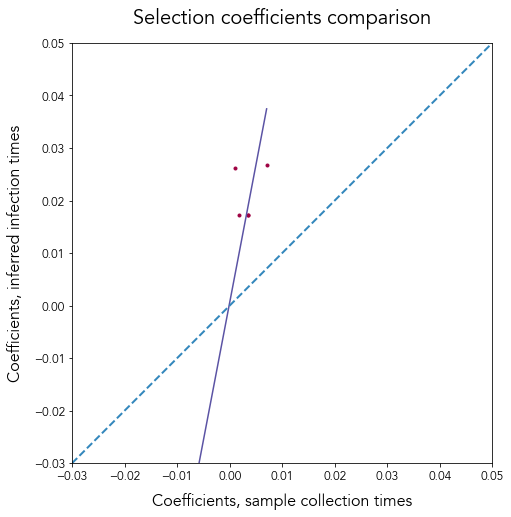

LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)


In [15]:
inf_topMut_figure(4, inf_plot_home, inf_plot_bp_home, plot_topMut_inf)

825
['209--', '209-A', '209-C', '209-G', '209-T', '240--', '240-A', '240-C', '240-G', '240-T', '568--', '568-A', '568-C', '568-G', '568-T', '1058--', '1058-A', '1058-C', '1058-G', '1058-T', '1190--', '1190-A', '1190-C', '1190-G', '1190-T', '1266--', '1266-A', '1266-C', '1266-G', '1266-T', '2831--', '2831-A', '2831-C', '2831-G', '2831-T', '3036--', '3036-A', '3036-C', '3036-G', '3036-T', '4180--', '4180-A', '4180-C', '4180-G', '4180-T', '5183--', '5183-A', '5183-C', '5183-G', '5183-T', '5385--', '5385-A', '5385-C', '5385-G', '5385-T', '5541--', '5541-A', '5541-C', '5541-G', '5541-T', '6401--', '6401-A', '6401-C', '6401-G', '6401-T', '6512--', '6512-A', '6512-C', '6512-G', '6512-T', '6513--', '6513-A', '6513-C', '6513-G', '6513-T', '6514--', '6514-A', '6514-C', '6514-G', '6514-T', '7123--', '7123-A', '7123-C', '7123-G', '7123-T', '8392--', '8392-A', '8392-C', '8392-G', '8392-T', '8985--', '8985-A', '8985-C', '8985-G', '8985-T', '9052--', '9052-A', '9052-C', '9052-G', '9052-T', '9890--', 

(<Figure size 720x288 with 1 Axes>, <Figure size 720x288 with 1 Axes>)

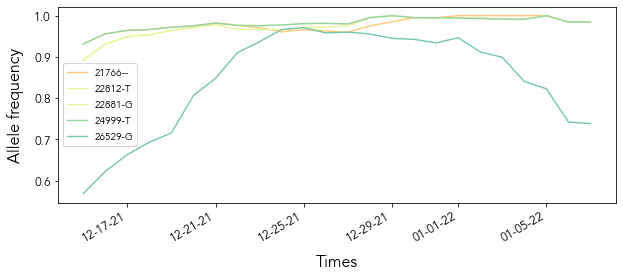

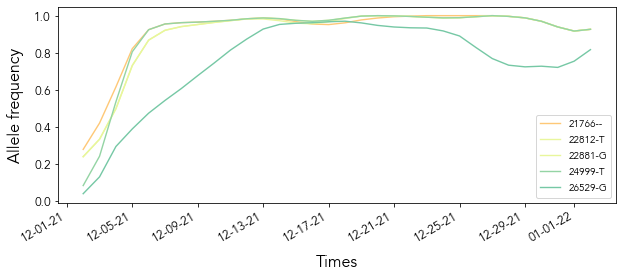

In [16]:
def plot_topMut_covar(x, y, z, plot_label):
    
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    index_drop = []

    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]

    df = df[~df['ref_index'].isin(index_drop)]

    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(10, 4))
    
    #for i in range(num_lines):
    print(num_lines)
    print(new_labels)
    # plot2: 
    #i_selected = [64,  84,  94,  99, 124, 128, 178, 264, 819]
    # plot107:
    #i_selected = [85,   86,   88,   89,  790,  791,  793,  794,  844, 1031]
    #i_selected = [89,  794, 1031]
    # plot4:
    i_selected = [290, 484, 488, 604, 638]
    for i in i_selected:
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, label=new_labels[i], linewidth=1.4, color=color)
    
    plt.subplots_adjust(bottom=0.15)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    ref_sites = extract_numeric(z)
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    plt.legend()

    return fig

def covar_topMut_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig1 = plot_topMut_covar(un_sel_x, un_sel_y, un_ref_z, f'Transmissions_{index}')
    fig2 = plot_topMut_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred_Infections_{index}')
    return fig1, fig2

covar_topMut_figure(4, home_dir)

(array([  89,  794, 1031]),)
['2469-T' '21594-T' '22598-A']


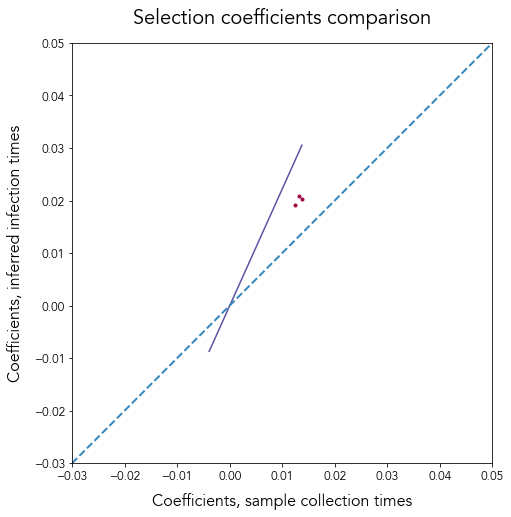

LinregressResult(slope=2.222984589452873, intercept=-5.1621537102829835e-05, rvalue=0.8824821056346607, pvalue=0.0, stderr=0.028668438590459727, intercept_stderr=3.4159427989405915e-05)


In [17]:
inf_topMut_figure(107, inf_plot_home, inf_plot_bp_home, plot_topMut_inf)

1710
['202--', '202-A', '202-C', '202-G', '202-T', '209--', '209-A', '209-C', '209-G', '209-T', '240--', '240-A', '240-C', '240-G', '240-T', '831--', '831-A', '831-C', '831-G', '831-T', '912--', '912-A', '912-C', '912-G', '912-T', '1058--', '1058-A', '1058-C', '1058-G', '1058-T', '1190--', '1190-A', '1190-C', '1190-G', '1190-T', '1266--', '1266-A', '1266-C', '1266-G', '1266-T', '1415--', '1415-A', '1415-C', '1415-G', '1415-T', '1819--', '1819-A', '1819-C', '1819-G', '1819-T', '1926--', '1926-A', '1926-C', '1926-G', '1926-T', '1956--', '1956-A', '1956-C', '1956-G', '1956-T', '2109--', '2109-A', '2109-C', '2109-G', '2109-T', '2257--', '2257-A', '2257-C', '2257-G', '2257-T', '2275--', '2275-A', '2275-C', '2275-G', '2275-T', '2345--', '2345-A', '2345-C', '2345-G', '2345-T', '2394--', '2394-A', '2394-C', '2394-G', '2394-T', '2469--', '2469-A', '2469-C', '2469-G', '2469-T', '2596--', '2596-A', '2596-C', '2596-G', '2596-T', '2831--', '2831-A', '2831-C', '2831-G', '2831-T', '3036--', '3036-A',

(<Figure size 720x288 with 1 Axes>, <Figure size 720x288 with 1 Axes>)

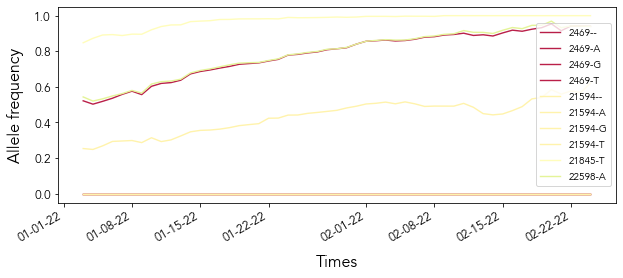

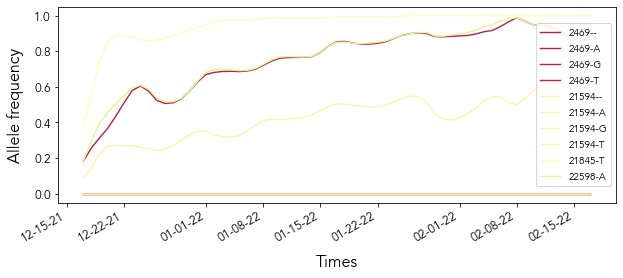

In [18]:
def plot_topMut_covar(x, y, z, plot_label):
    
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    
    sites = z
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    index_drop = []

    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]

    df = df[~df['ref_index'].isin(index_drop)]

    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]
    
    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(10, 4))
    
    #for i in range(num_lines):
    print(num_lines)
    print(new_labels)
    # plot2: i_selected = [64,  84,  94,  99, 124, 128, 178, 264, 819]
    #plot107
    i_selected = [85,   86,   88,   89,  790,  791,  793,  794,  844, 1031]
    #i_selected = [89,  794, 1031]
    #4
    #i_selected = [290, 484, 488, 604, 638]
    for i in i_selected:
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, label=new_labels[i], linewidth=1.4, color=color)
    
    plt.subplots_adjust(bottom=0.15)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    fig.autofmt_xdate()

    ax.set_xlabel('Times', font='Avenir', size=16, labelpad=10)
    ax.set_ylabel('Allele frequency', font='Avenir', size=16, labelpad=10)
    
    ref_sites = extract_numeric(z)
    #percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.2)
    #cbar = plt.colorbar(scalar_map, cax=cax)
    
    #cbar.set_label('Mutation sites', font='Avenir', size=16, labelpad=20)
    #cbar.set_ticks(percentiles)
    #cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    
    #for label in cbar.ax.get_yticklabels():
    #    label.set_fontname('Avenir')
    #    label.set_fontsize(12)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
    
    plt.legend()

    #save_path = username + f'/paper-epi-backprojection/figures/covar_topMut_{plot_label}.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

def covar_topMut_figure(index, home_dir):
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])

    fig1 = plot_topMut_covar(un_sel_x, un_sel_y, un_ref_z, f'Transmissions_{index}')
    fig2 = plot_topMut_covar(bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred_Infections_{index}')
    return fig1, fig2

covar_topMut_figure(107, home_dir)

### individual mutation plots (for thesis)

In [19]:
def plot_single_inf(ax, x, y, mut1, mut2, index):
    mpl.rc('font', family='Avenir')
    #plt.subplots(figsize=(12,12))
    #plt.subplots(figsize=(8,8))
    y_val = y > 0.015
    indices_where = np.where(y_val)
    y_other = (y < 0.015) #& (x < 0.015)
    indices_not = np.where(y_other)
    print(indices_where)
    #mutant = input(str("type mutation: "))
    print(mut1[0][indices_where])
    #for i in indices_where:
    for i in indices_where:
        plt.plot(x[i], y[i], 'o', label=mut2, color=rgba1, markersize=0.6)
    for i in indices_not:
        plt.plot(x[i], y[i], 'o', label=mut2, color='xkcd:cloudy blue', markersize=0.6)
    
    
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6, linewidth=1.2)
    

    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5,linestyle='dashed',linewidth=1.2)
    ax.set_xlim(xmin=-.03, xmax=.05)
    ax.set_ylim(ymin=-.03, ymax=.05)

    #ax.set_xlabel('Coefficients, sample collections', font='Avenir', size=16, labelpad=10)
    #ax.set_ylabel('Coefficients, inferred infections', font='Avenir', size=16, labelpad=10)
    #plt.title('Selection coefficients comparison', font='Avenir', size=20, pad=20)
    #plt.subplots_adjust(bottom=0.15)

    #ax.set_aspect('equal', adjustable='box')
    
    #ax.tick_params(axis='x', labelsize=12)
    #ax.tick_params(axis='y', labelsize=12)
    #for label in ax.get_xticklabels() + ax.get_yticklabels():
    #    label.set_fontname('Avenir')
    
    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collections'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infections'
    #x_title = r"$\pi$"
    ax.set_xlabel(xlabel=x_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Avenir', size=12, labelpad=5, math_fontfamily='stixsans')

    #ax.set_xlabel('Coefficients, sample collections', font='Avenir', size=16, labelpad=10)
    #ax.set_ylabel('Coefficients, inferred infections', font='Avenir', size=16, labelpad=10)
    #plt.title('Selection Coefficients: Transmissions vs. Infections', font='Avenir', size=20, pad=20)
    plt.subplots_adjust(bottom=0.15)

    ax.set_aspect('equal', adjustable='box')
    
    ax.tick_params(axis='x', labelsize=12, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')
        
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    lr = linregress(x, y)
        
    custom_shapes = [Line2D([0], [0], marker='o', color='w', alpha=0),
                     Line2D([0], [0], marker='o', color='w', alpha=0)]    
    custom_labels = ['m:  ' + str(round(lr.slope, 3)), 'R:  ' + str(round(lr.rvalue, 3))]
    
    ax.legend(custom_shapes, custom_labels, loc='lower right', fontsize=12, labelcolor=rgba6, frameon=False)

    
    #save_path = username + f'/paper-epi-backprojection/figures/inf_ppt_{index}.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    #plt.show()
    #save_path = username + f'/paper-epi-backprojection/figures/infer_ppt_wyoming.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(linregress(x, y))

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
(array([290, 484, 488, 604, 638]),)
['21766--' '22812-T' '22881-G' '24999-T' '26529-G']
LinregressResult(slope=5.242413445421102, intercept=0.0005368459464822001, rvalue=0.7177039191323045, pvalue=1.7137291902479058e-131, stderr=0.17730158218307998, intercept_stderr=0.0001472846349890924)


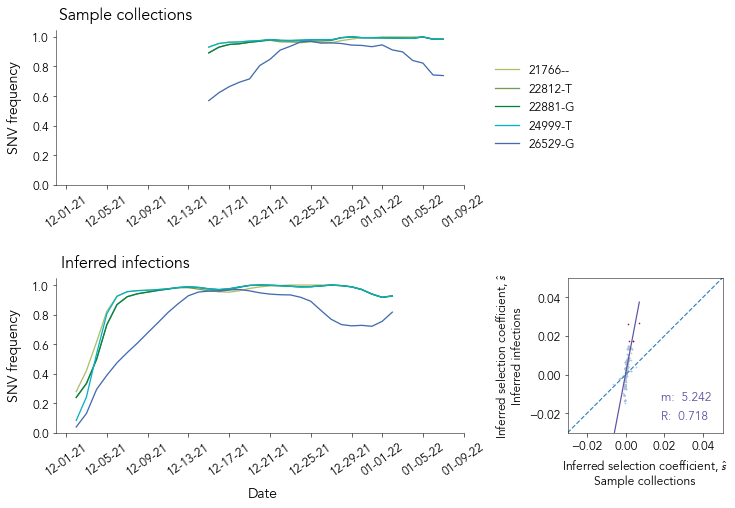

In [23]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

def plot_single_covar(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Avenir')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    #for i in range(num_lines):
    #    if i not in indices:
    #        y_line = y[:, i]
    ##        color = scalar_map.to_rgba(i)
    #        ax.plot(x_dates, y_line, linewidth=1.2, color=color)
    
    #for i in range(num_lines):
    #print(num_lines)
    #print(new_labels)
    # plot2: i_selected = [64,  84,  94,  99, 124, 128, 178, 264, 819]
    #plot107
    #i_selected = [85,   86,   88,   89,  790,  791,  793,  794,  844, 1031]
    #i_selected = [89,  794, 1031]
    #4
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)

    i_selected = [290, 484, 488, 604, 638]
    i_color = ['xkcd:light olive', 'xkcd:moss', 'xkcd:jungle green', 'xkcd:turquoise blue', 'xkcd:french blue']
    #i_color = ['xkcd:light olive', 'xkcd:turtle green', 'xkcd:seaweed green', 
    #           'xkcd:sea blue', 'xkcd:topaz']
    
    #i_selected = [89, 794,  844, 1031]
    #i_selected = [89,  794, 1031]
        #i_selected = [290, 484, 488, 604, 638]
    #i_color = ['xkcd:light olive', 'xkcd:sage green', 'xkcd:jungle green', 'xkcd:sea blue', 'xkcd:french blue']
    #i_color = ['xkcd:pale red', 'xkcd:gold', 'xkcd:soft green', 'xkcd:dark sea green']

    for i in range(num_lines):
        x_line = x
        y_line = y[:, i]

        if i in i_selected:
            custom_color = i_color[i_selected.index(i)]
            ax.plot(x_dates, y_line, label=new_labels[i], linewidth=1.3, color=custom_color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=12, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=12, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Avenir')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.17, y=1.03, fontsize=16)
    
    ax.set_ylim(0,1.05)
    
    if plot_label == 'Sample collections':
        ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), frameon=False, fontsize=12)

def supp_figure_single(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    un_mut = x['mutant_sites']
    bp_mut = y['mutant_sites']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(12, 7))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.6)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)
    ax2.set_ylabel('SNV frequency', font='Avenir', size=14, labelpad=10)

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_single_covar(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_single_covar(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_single_inf(ax3, un_sel, bp_sel, un_mut, bp_mut, index)
    
    
    fig.supxlabel('Date', fontsize=14, y=-0.035, x=0.34)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=1)
    
    #save_path = username + f'/paper-epi-backprojection/figures/thesis_single_{index}.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

fig = supp_figure_single(4, home_dir)